In [1]:
import tensorflow as tf  
 
print(tf.__version__)    

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout 
from tensorflow.keras.layers import MaxPooling2D
import cv2
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns

2.8.0


In [2]:
#Data preprocessing
def data_preprocessing(data, grayscale):

    #Distribute it to train and test set
    (x_train, y_train), (x_test, y_test) = data.load_data()

    #Grayscaled representation of the data
    if grayscale:
        x_train_new = []
        x_test_new  = []
        for i in x_train:
            x_train_new.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
        for i in x_test:
            x_test_new.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
        
        x_train = np.array(x_train_new)
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

        x_test  = np.array(x_test_new)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

        print("grayscaled shape x_train", x_train.shape)
        print("grayscaled shape x_test", x_test.shape)
    
    #Data normalization
    x_train = x_train/255
    x_test = x_test/255

    #Categorical representation of the labels
    y_train_categorical = keras.utils.to_categorical(y_train,10)
    y_test_categorical = keras.utils.to_categorical(y_test,10)

    return x_train, x_test, y_train_categorical, y_test_categorical, y_test

#Show firsts 3 smaples of the training dataset
def show_img(x_train, y_train, labels, grayscaled):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,14))

    #reshaped data for grayscaled images
    if grayscaled:
        ax1.imshow(x_train[0].reshape(32,32), cmap="gray")
        ax1.set_title(labels[np.argmax(y_train[0])])
        ax2.imshow(x_train[1].reshape(32,32), cmap="gray")
        ax2.set_title(labels[np.argmax(y_train[1])])
        ax3.imshow(x_train[2].reshape(32,32), cmap="gray")
        ax3.set_title(labels[np.argmax(y_train[2])])

    else:
        ax1.imshow(x_train[0])
        ax1.set_title(labels[np.argmax(y_train[0])])
        ax2.imshow(x_train[1])
        ax2.set_title(labels[np.argmax(y_train[1])])
        ax3.imshow(x_train[2])
        ax3.set_title(labels[np.argmax(y_train[2])])

#Show some missclassified images
def show_missclassified_img(model, x_test, y_test, amount, labels, gray, conf_matrix):

    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)

    y_test = y_test.reshape(y_test.shape[0])
    print("predicted", pred[:20])
    print("y_test", y_test[:20])

    compare = pred == y_test

    x_misscl    = x_test[~compare]
    pred_misscl = pred[~compare]

    print(x_misscl.shape)

    for i in range(amount):
        print("Model prediction: "+str(labels[pred_misscl[i]]))
        if gray:
            plt.imshow(x_misscl[i].reshape(32,32), cmap="gray")
            plt.show()
        else:
            plt.imshow(x_misscl[i])
            plt.show()

    #Draw confusion matrix
    if conf_matrix:
        confMat = confusion_matrix(y_test, pred)
        plt.figure(figsize=(12,12))
        sns.heatmap(confMat, cbar=False, xticklabels=labels, yticklabels=labels, fmt="d", annot=True, cmap=plt.cm.Blues)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return compare

#Show some images, that were missclassified by the FCNN, but correctely classified 
#by CNN model
def compareResults(maskCNN, maskFCNN, y_test, labels, amount):

    maskCompare = np.logical_and(maskCNN, np.logical_not(maskFCNN))
    x_misscl    = x_test[maskCompare]
    y_test      = y_test.reshape(y_test.shape[0])
    label       = y_test[maskCompare]

    for i in range(amount):
        print("Correct label: "+str(labels[label[i]]))
        plt.imshow(x_misscl[i])
        plt.show()

#Check fraction of initial variance of the data, after applying PCA
def check_var_pca(data, remVar, step, start):

    #Flatten data
    new_data = np.reshape(data, (data.shape[0], np.prod(data.shape[1:4])))

    var     = 0
    counter = start

    while var < remVar:
        pca_d = PCA(n_components=counter)
        pca_d.fit(new_data)
        var = sum(pca_d.explained_variance_ratio_)        
        print("# of principal components:", counter, " varinace: ", var)
        counter += step

    return counter

#Use PCA for the dimensionality reduction of the data
def myPca(data, test_data, nComponents):

    new_data = np.reshape(data, (data.shape[0], np.prod(data.shape[1:4])))
    new_test = np.reshape(test_data, (test_data.shape[0], np.prod(test_data.shape[1:4])))

    pca_d = PCA(n_components=nComponents)
    pca_d.fit(new_data)

    new_d    = pca_d.transform(new_data)
    new_test = pca_d.transform(new_test)

    return new_d, new_test

#Plot accuracies and losses on the validation and train dataset dependent on the
#epochs of the training 
def drawAcc(his): 
  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

    ax1.plot(his.history['accuracy'])
    ax1.plot(his.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val'], loc='upper left')

    ax2.plot(his.history['loss'])
    ax2.plot(his.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'val'], loc='upper left')


#Simple fully connected neuronal network architecture 
#parameter arch - number of neurons in each layer, len of arch - number of layers
#numPC - number of principal components 
def simpleNN(x_train, x_test, y_train, y_test, arch, numPC, dropout, dropoutP, flatten, channels):

    architecture = []

    if flatten:
        architecture.append(Flatten(input_shape=(32, 32, channels)))
        for i in range(len(arch)):
            architecture.append(Dense(arch[i], activation='relu'))
            if dropout:
                architecture.append(Dropout(dropoutP))
        architecture.append(Dense(10, activation='softmax'))

        model_SNN = keras.Sequential(architecture)

    else:
        architecture.append(Dense(arch[0], input_dim = numPC, activation='relu'))
        if dropout:
            architecture.append(Dropout(dropoutP))
        for i in range(1, len(arch)):
            architecture.append(Dense(arch[i], activation='relu'))
            if dropout:
                architecture.append(Dropout(dropoutP))
        architecture.append(Dense(10, activation='softmax'))

        model_SNN = keras.Sequential(architecture)

    print(model_SNN.summary())
    model_SNN.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    his = model_SNN.fit(x_train, y_train, batch_size=64, epochs=30, 
                            validation_split=0.2)
    
    model_SNN.evaluate(x_test, y_test)
    drawAcc(his)

    return model_SNN


#Convolutional neural network architecture
#paramsFCNN - number of neurons in each layer, len of paramsFCNN - number of layers
#paramsCNN - parameters for CNN [1st layer: number of filters, kernel size for maxpooling layer, stride for maxpooling layer, 2nd layer: ...]
def cnnModels(x_train, x_test, y_train, y_test, paramsCNN, paramsFCNN, NumberOfEpochs, batchSize, optimizer, dropout, dropoutP, channels):
    architecture = []
    activFunc    = keras.layers.LeakyReLU(alpha=0.02) 


    for i in range(0, len(paramsCNN), 3):
        if i == 0: 
            architecture.append(Conv2D(paramsCNN[i], (3,3), padding='same', activation=activFunc, input_shape=(32,32,channels)))
        else:
            architecture.append(Conv2D(paramsCNN[i], (3,3), padding='same', activation=activFunc))
        architecture.append(MaxPooling2D((paramsCNN[i+1], paramsCNN[i+1]), strides=paramsCNN[i+2], padding='valid'))
        if dropout:
           architecture.append(Dropout(dropoutP)) 
    
    architecture.append(Flatten())
    
    for j in range(len(paramsFCNN)):
        architecture.append(Dense(paramsFCNN[j], activation=activFunc))

    architecture.append(Dense(10, activation='softmax'))

    model = keras.Sequential(architecture)
    print(model.summary())

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    his = model.fit(x_train, y_train, batch_size=batchSize, epochs=NumberOfEpochs, 
                validation_split=0.2)
    
    model.evaluate(x_test, y_test)
    drawAcc(his)

    return model

**Original data (colour images - 3 channels)**

**Load and preprocess the data**

In [3]:
cifar10 = tf.keras.datasets.cifar10
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 
          'Frog', 'Horse', 'Ship', 'Truck']
  
x_train, x_test, y_train, y_test, y_test_init = data_preprocessing(cifar10, False)

170508288/170498071 [==============================] - 2s 0us/step


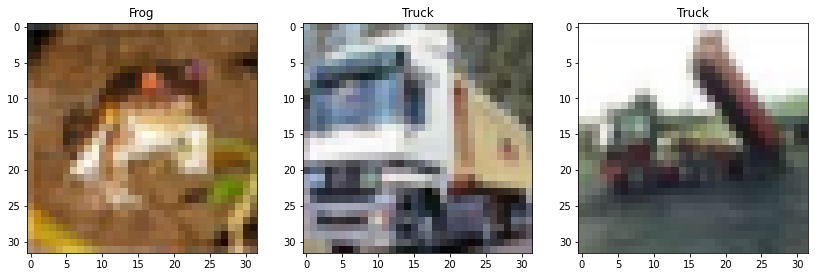

In [5]:
#show some images in the dataset
show_img(x_train, y_train, labels, False)

**Principal component analysis**

In [48]:
#Number of principal components, that remain 90% of variance information
check_var_pca(x_train, 0.9, 5, 5)

# of principal components: 5  varinace:  0.5430948931193366
# of principal components: 10  varinace:  0.655015155507673
# of principal components: 15  varinace:  0.7085076051734831
# of principal components: 20  varinace:  0.7445435515122982
# of principal components: 25  varinace:  0.7710287016883607
# of principal components: 30  varinace:  0.792585280967214
# of principal components: 35  varinace:  0.8089938963018568
# of principal components: 40  varinace:  0.822126221673194
# of principal components: 45  varinace:  0.8334433687660444
# of principal components: 50  varinace:  0.842963777002116
# of principal components: 55  varinace:  0.8515096486370498
# of principal components: 60  varinace:  0.8592300095342336
# of principal components: 65  varinace:  0.8662285036223979
# of principal components: 70  varinace:  0.8724918859750268
# of principal components: 75  varinace:  0.8782537893804715
# of principal components: 80  varinace:  0.8835628901938575
# of principal components: 85

105

In [49]:
#Number of principal components, that remain 95% of variance information
check_var_pca(x_train, 0.95, 10, 100)

# of principal components: 100  varinace:  0.9009814687737369
# of principal components: 110  varinace:  0.9078785941597174
# of principal components: 120  varinace:  0.9140085904260071
# of principal components: 130  varinace:  0.9194922013979726
# of principal components: 140  varinace:  0.9243614429436247
# of principal components: 150  varinace:  0.9288056734818688
# of principal components: 160  varinace:  0.9328417258505323
# of principal components: 170  varinace:  0.9364652204757774
# of principal components: 180  varinace:  0.939814655188743
# of principal components: 190  varinace:  0.9429065505247336
# of principal components: 200  varinace:  0.9457485053896221
# of principal components: 210  varinace:  0.9484049681130654
# of principal components: 220  varinace:  0.9508329456815846


230

In [8]:
#first 100 pc (remain 90% of initial variance information)
x_train_reduced, x_test_reduced = myPca(x_train, x_test, 100)
print(x_train_reduced.shape)
print(x_test_reduced.shape)

(50000, 100)
(10000, 100)


In [9]:
#first 225 pc (remain 95% of initial variance information)
x_train_reduced_2, x_test_reduced_2 = myPca(x_train, x_test, 225)
print(x_train_reduced_2.shape)
print(x_test_reduced_2.shape)

(50000, 225)
(10000, 225)


**Experiments with simple fully-connected neuronal network**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1000)              3073000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               150300    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0

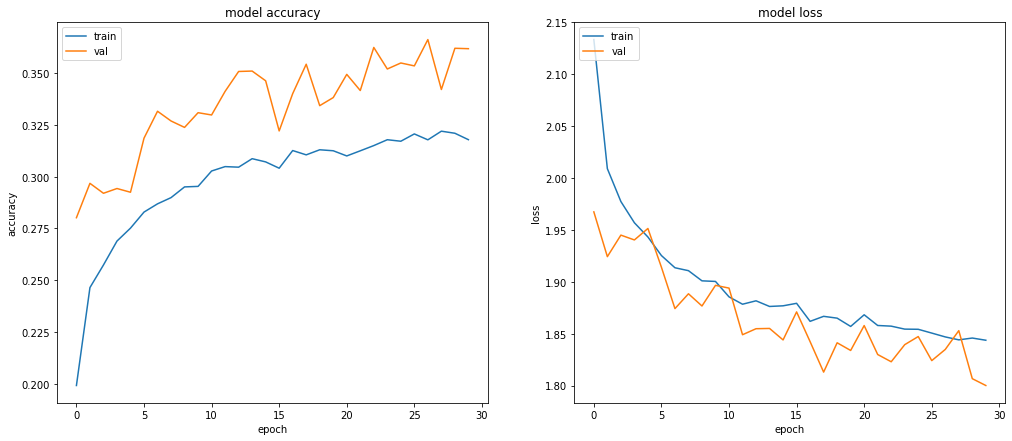

In [4]:
#Simple NN
#All data without using PCA
arch1 = [1000, 500, 300]
model = simpleNN(x_train, x_test, y_train, y_test, arch1, 0, True, 0.4, True, 3)

predicted [3 9 8 8 6 6 3 6 3 1 8 9 6 7 9 8 5 7 8 6]
y_test [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]
(6305, 32, 32, 3)
Model prediction: Truck


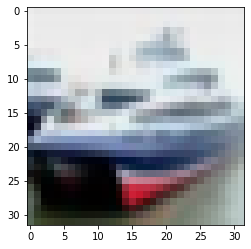

Model prediction: Ship


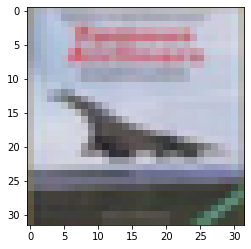

Model prediction: Cat


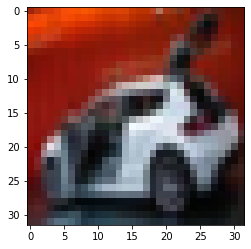

Model prediction: Ship


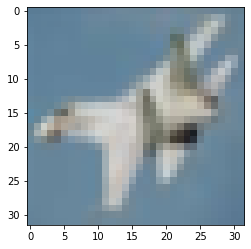

Model prediction: Frog


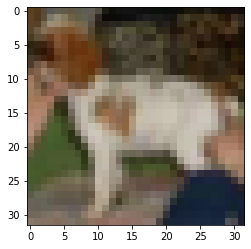

Model prediction: Bird


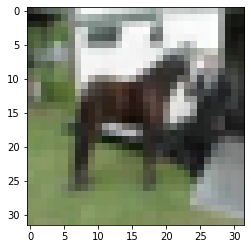

Model prediction: Airplane


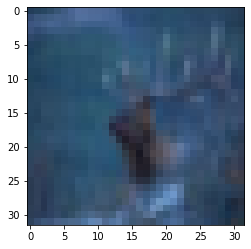

Model prediction: Deer


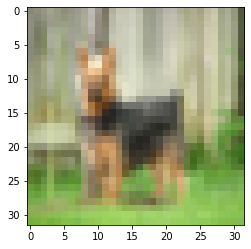

Model prediction: Cat


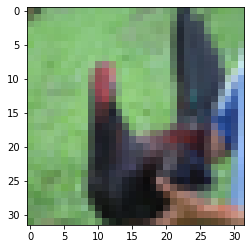

Model prediction: Frog


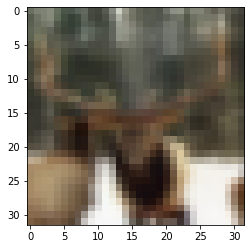

Model prediction: Horse


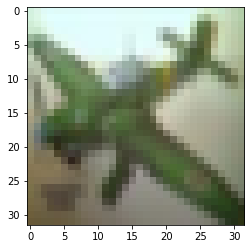

Model prediction: Automobile


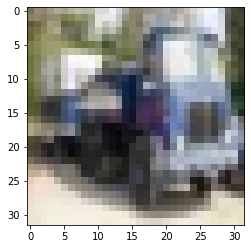

Model prediction: Cat


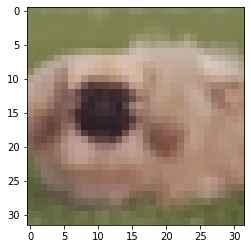

Model prediction: Cat


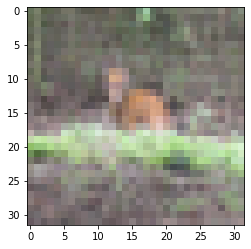

Model prediction: Frog


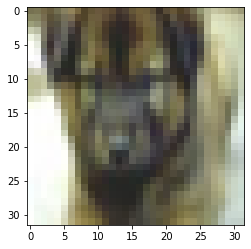

Model prediction: Truck


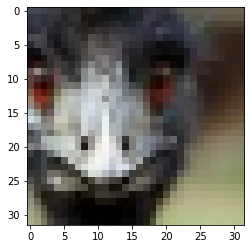

Model prediction: Frog


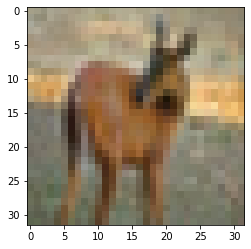

Model prediction: Truck


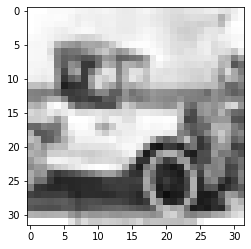

Model prediction: Automobile


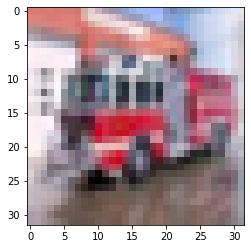

Model prediction: Cat


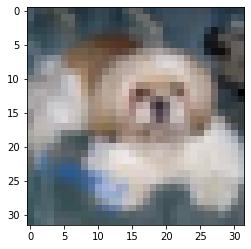

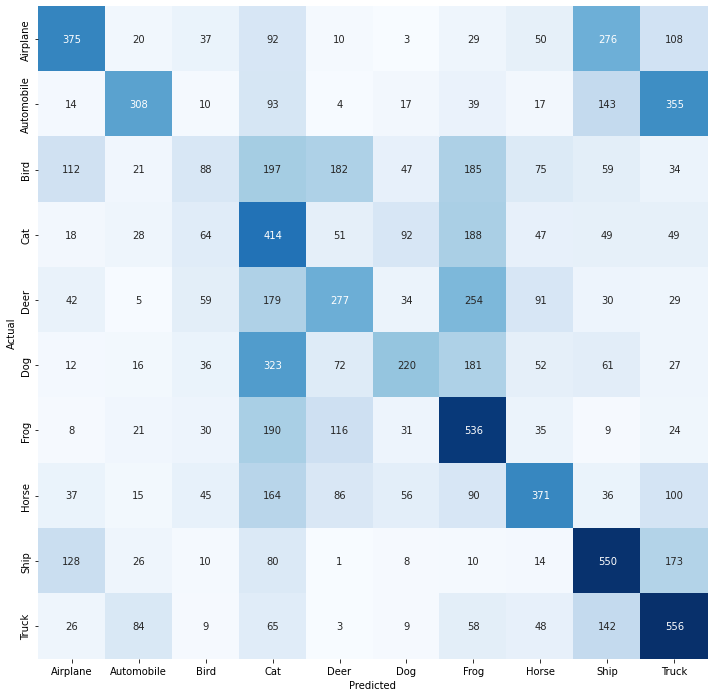

In [7]:
#show some missclassified images and confusion matrix
maskFCNN = show_missclassified_img(model, x_test, y_test_init, 20, labels, False, True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              101000    
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               150300    
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 dense_7 (Dense)             (None, 10)               

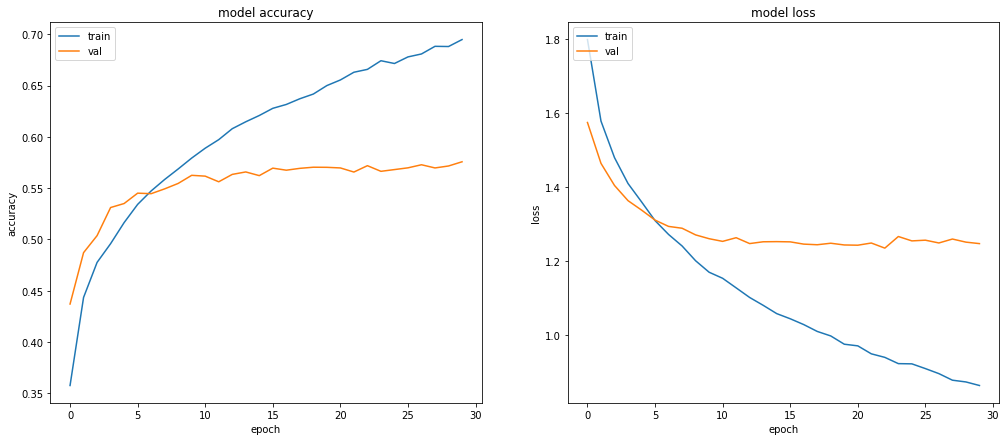

In [14]:
#Simple NN
#All data with PCA (100 PC, 90% of init variance)
arch1 = [1000, 500, 300]
simpleNN(x_train_reduced, x_test_reduced, y_train, y_test, arch1, 100, True, 0.4, False, 3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              226000    
                                                                 
 dropout_6 (Dropout)         (None, 1000)              0         
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 300)               150300    
                                                                 
 dropout_8 (Dropout)         (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 10)               

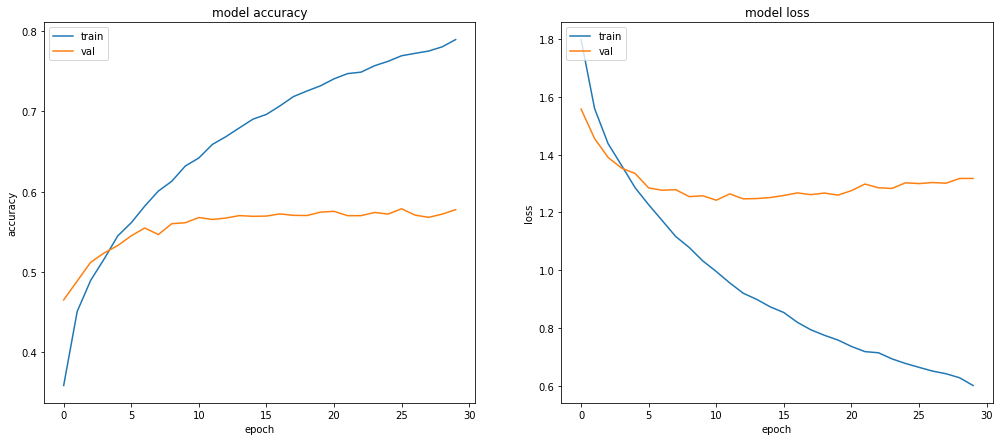

In [15]:
#Simple NN
#All data with PCA (225 PC, 95% of init variance)
arch1 = [1000, 500, 300]
simpleNN(x_train_reduced_2, x_test_reduced_2, y_train, y_test, arch1, 225, True, 0.4, False, 3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 10)               

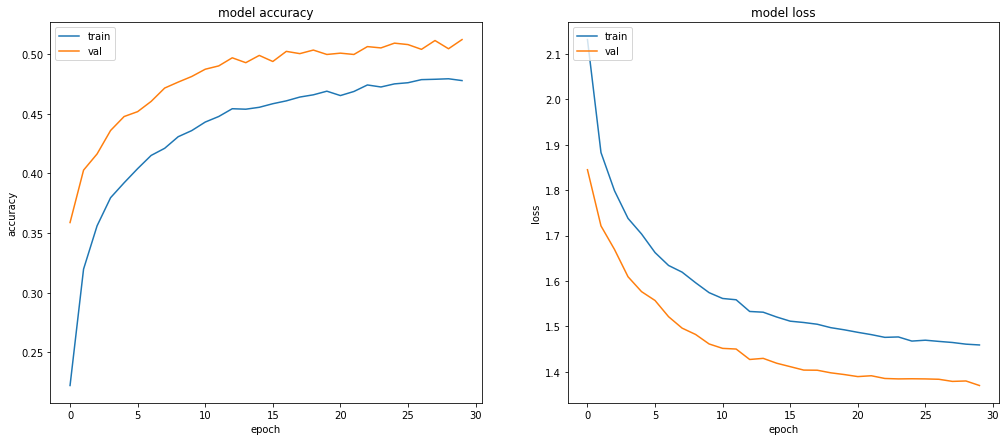

In [16]:
#Simple NN
#All data with PCA (100 PC, 90% of init variance)
arch1 = [100, 100, 100]
simpleNN(x_train_reduced, x_test_reduced, y_train, y_test, arch1, 100, True, 0.4, False, 3)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               22600     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 10)               

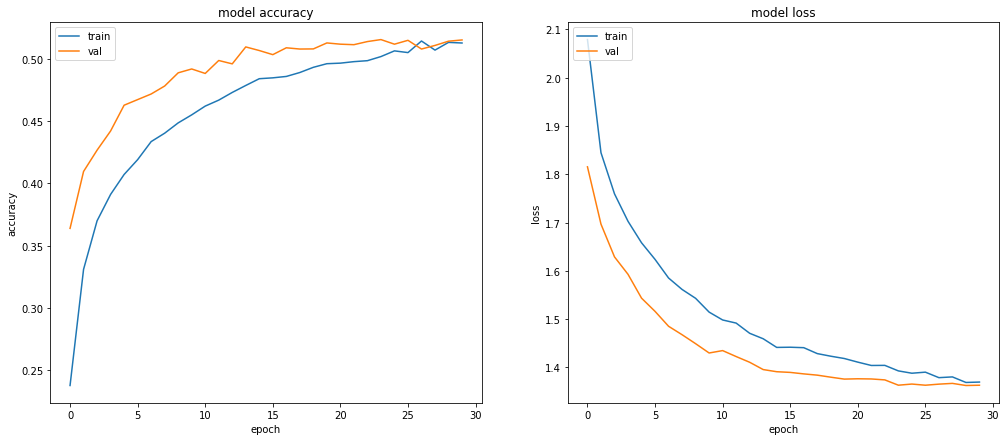

In [17]:
#Simple NN
#All data with PCA (225 PC, 95% of init variance)
arch1 = [100, 100, 100]
simpleNN(x_train_reduced_2, x_test_reduced_2, y_train, y_test, arch1, 225, True, 0.4, False, 3)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 200)               20200     
                                                                 
 dropout_15 (Dropout)        (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 200)               40200     
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_22 (Dense)            (None, 200)               40200     
                                                                 
 dropout_17 (Dropout)        (None, 200)               0         
                                                                 
 dense_23 (Dense)            (None, 10)               

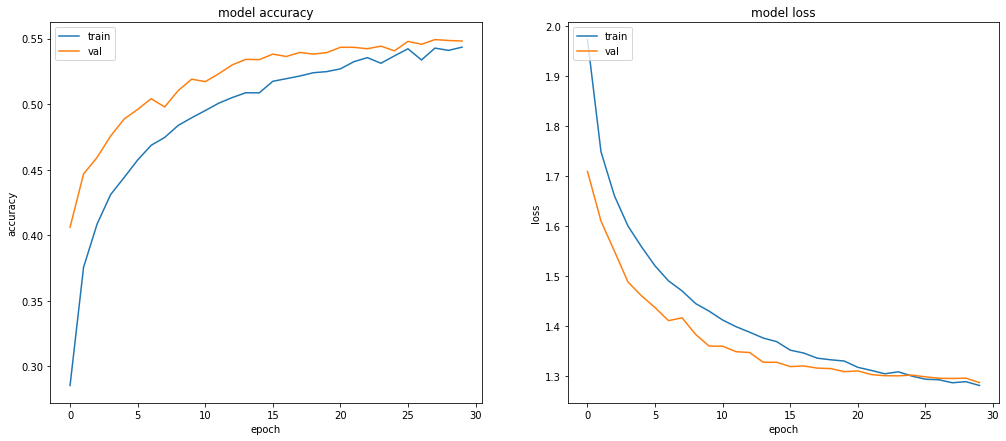

In [18]:
#Simple NN
#All data with PCA (100 PC, 90% of init variance)
arch1 = [200, 200, 200]
simpleNN(x_train_reduced, x_test_reduced, y_train, y_test, arch1, 100, True, 0.4, False, 3)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 200)               45200     
                                                                 
 dropout_18 (Dropout)        (None, 200)               0         
                                                                 
 dense_25 (Dense)            (None, 200)               40200     
                                                                 
 dropout_19 (Dropout)        (None, 200)               0         
                                                                 
 dense_26 (Dense)            (None, 200)               40200     
                                                                 
 dropout_20 (Dropout)        (None, 200)               0         
                                                                 
 dense_27 (Dense)            (None, 10)               

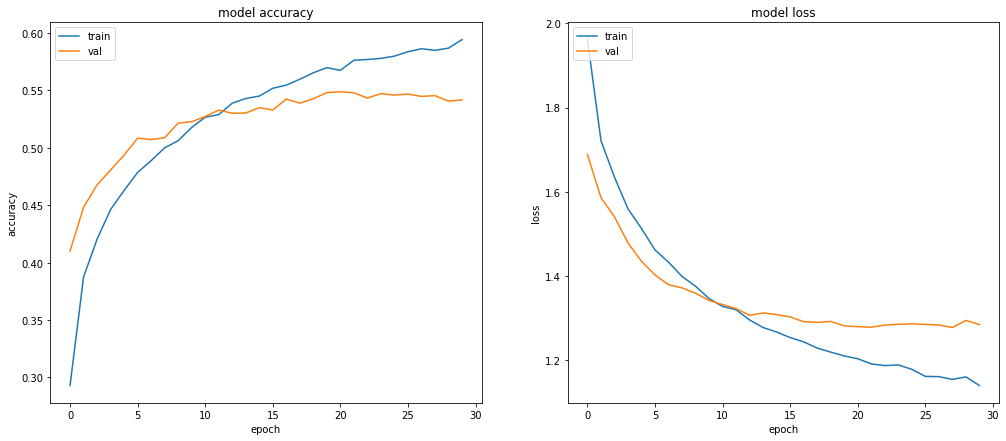

In [19]:
#Simple NN
#All data with PCA (225 PC, 95% of init variance)
arch1 = [200, 200, 200]
simpleNN(x_train_reduced_2, x_test_reduced_2, y_train, y_test, arch1, 225, True, 0.4, False, 3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 300)               30300     
                                                                 
 dropout_21 (Dropout)        (None, 300)               0         
                                                                 
 dense_29 (Dense)            (None, 300)               90300     
                                                                 
 dropout_22 (Dropout)        (None, 300)               0         
                                                                 
 dense_30 (Dense)            (None, 300)               90300     
                                                                 
 dropout_23 (Dropout)        (None, 300)               0         
                                                                 
 dense_31 (Dense)            (None, 10)               

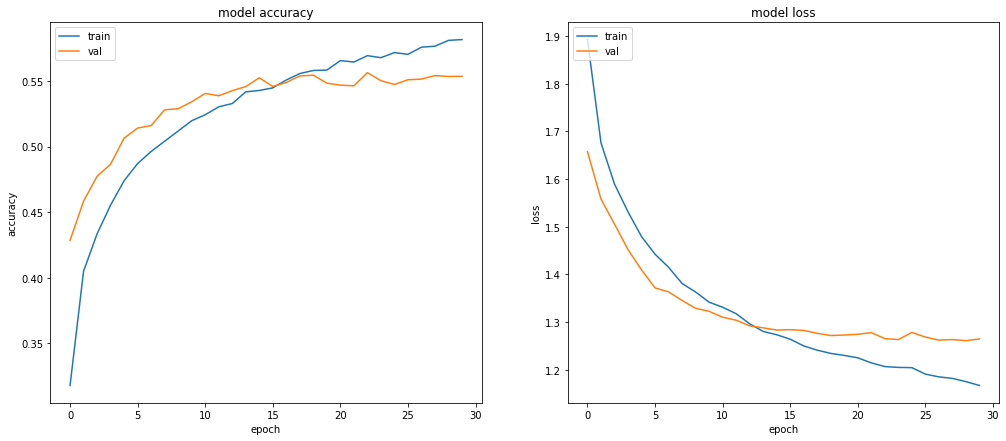

In [20]:
#Simple NN
#All data with PCA (100 PC, 90% of init variance)
arch1 = [300, 300, 300]
simpleNN(x_train_reduced, x_test_reduced, y_train, y_test, arch1, 100, True, 0.4, False, 3)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 300)               67800     
                                                                 
 dropout_24 (Dropout)        (None, 300)               0         
                                                                 
 dense_33 (Dense)            (None, 300)               90300     
                                                                 
 dropout_25 (Dropout)        (None, 300)               0         
                                                                 
 dense_34 (Dense)            (None, 300)               90300     
                                                                 
 dropout_26 (Dropout)        (None, 300)               0         
                                                                 
 dense_35 (Dense)            (None, 10)               

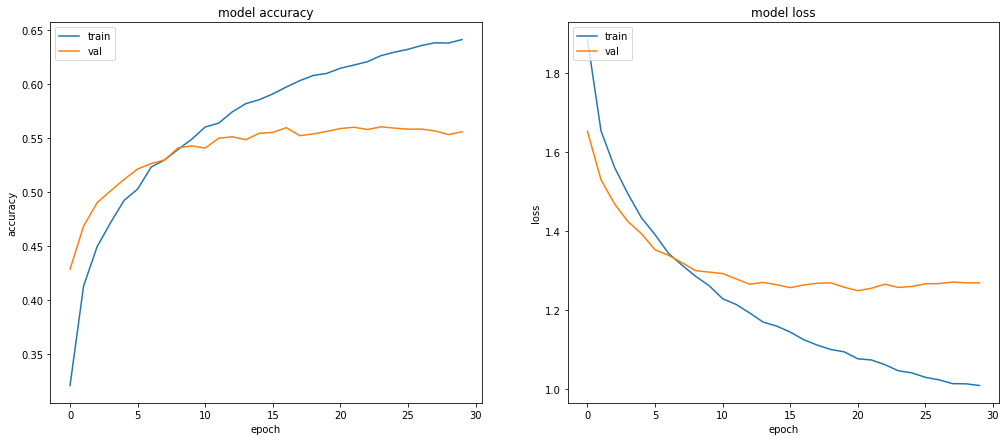

In [21]:
#Simple NN
#All data with PCA (225 PC, 95% of init variance)
arch1 = [300, 300, 300]
simpleNN(x_train_reduced_2, x_test_reduced_2, y_train, y_test, arch1, 225, True, 0.4, False, 3)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               22600     
                                                                 
 dropout_27 (Dropout)        (None, 100)               0         
                                                                 
 dense_37 (Dense)            (None, 100)               10100     
                                                                 
 dropout_28 (Dropout)        (None, 100)               0         
                                                                 
 dense_38 (Dense)            (None, 10)                1010      
                                                                 
Total params: 33,710
Trainable params: 33,710
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
625/625 [=========================

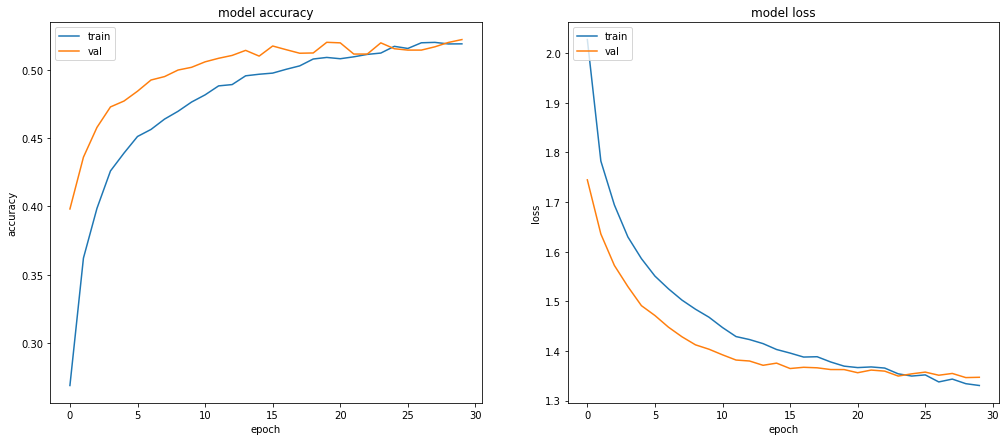

In [22]:
#Simple NN
#All data with PCA (225 PC, 95% of init variance)
arch1 = [100, 100]
simpleNN(x_train_reduced_2, x_test_reduced_2, y_train, y_test, arch1, 225, True, 0.4, False, 3)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 500)               113000    
                                                                 
 dropout_29 (Dropout)        (None, 500)               0         
                                                                 
 dense_40 (Dense)            (None, 500)               250500    
                                                                 
 dropout_30 (Dropout)        (None, 500)               0         
                                                                 
 dense_41 (Dense)            (None, 10)                5010      
                                                                 
Total params: 368,510
Trainable params: 368,510
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
625/625 [======================

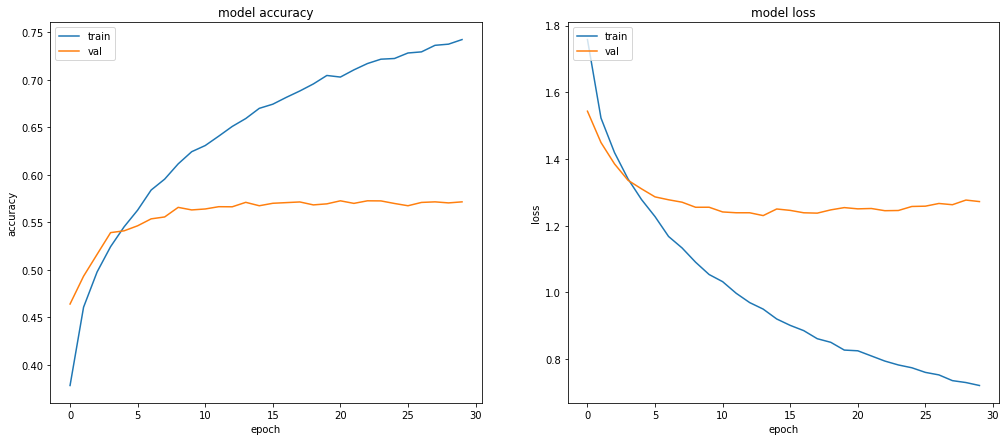

In [23]:
#Simple NN
#All data with PCA (225 PC, 95% of init variance)
arch1 = [500, 500]
simpleNN(x_train_reduced_2, x_test_reduced_2, y_train, y_test, arch1, 225, True, 0.4, False, 3)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 200)               45200     
                                                                 
 dropout_31 (Dropout)        (None, 200)               0         
                                                                 
 dense_43 (Dense)            (None, 200)               40200     
                                                                 
 dropout_32 (Dropout)        (None, 200)               0         
                                                                 
 dense_44 (Dense)            (None, 200)               40200     
                                                                 
 dropout_33 (Dropout)        (None, 200)               0         
                                                                 
 dense_45 (Dense)            (None, 100)             

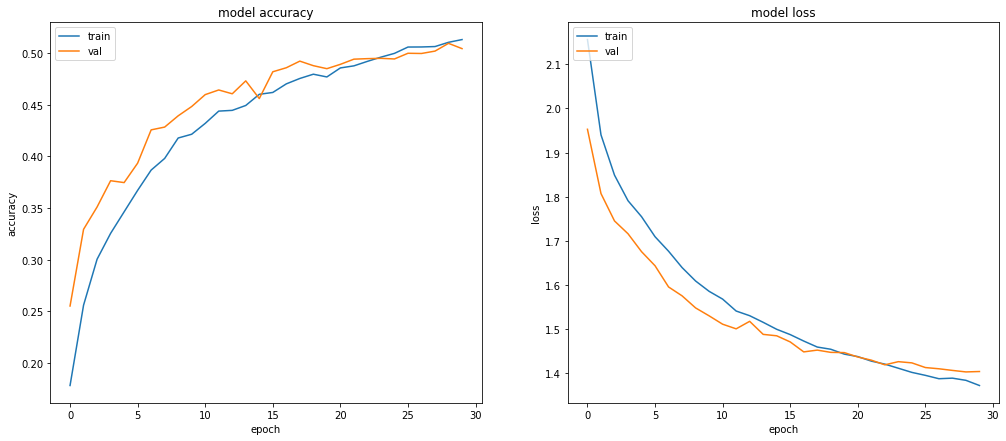

In [24]:
#Simple NN
#All data with PCA (225 PC, 95% of init variance)
arch1 = [200, 200, 200, 100, 100, 100]
simpleNN(x_train_reduced_2, x_test_reduced_2, y_train, y_test, arch1, 225, True, 0.4, False, 3)

**Experiments with Convolutional neuronal networks**

In [ ]:
#params CNN: cnnModels(x_train, x_test, y_train, y_test, paramsCNN, paramsFCNN, NumberOfEpochs, batchSize, optimizer, dropout, dropoutP, channels)
#paramsCNN - (number of filters 1st layer, maxPooling kernel size 1st layer, stride maxPooling 1st layer, ... 2nd layer, 3rd layer, ...)
#paramsFCNN - (number of neurons 1st layer, ... 2nd layer, ...)

**CNN architecture with FCNN head without dropout**

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 256)      

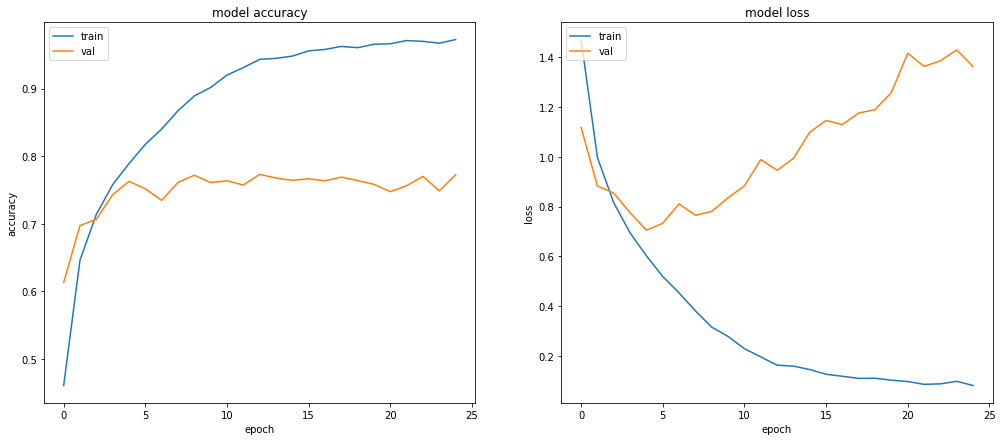

In [25]:
#CNN model 1
paramsCNN  = [64, 4, 2, 128, 4, 2, 256, 4, 2]
paramsFCNN = [128]

cnnModels(x_train, x_test, y_train, y_test, paramsCNN, paramsFCNN, 25, 64, 'adam', False, 0.25, 3)

**CNN architecture without FCNN head without dropout**

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 256)         295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 256)      

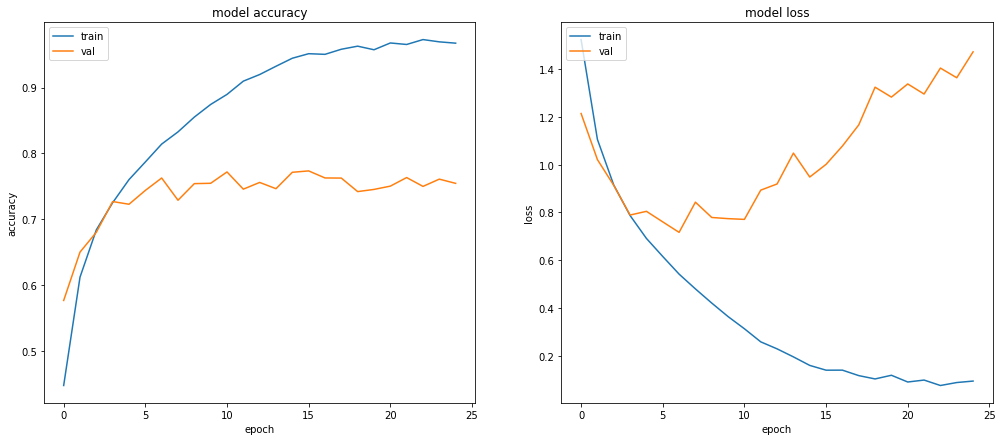

In [26]:
#CNN model 2
paramsCNN  = [64, 4, 2, 128, 4, 2, 256, 4, 2]
paramsFCNN = []

cnnModels(x_train, x_test, y_train, y_test, paramsCNN, paramsFCNN, 25, 64, 'adam', False, 0.25, 3)

**CNN architecture with FCNN head (1 layer) with dropout (0.4)**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 128)        

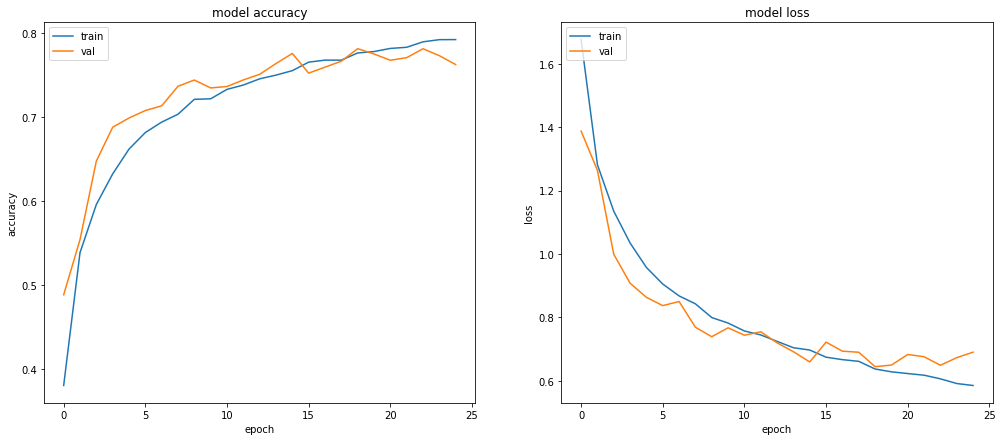

In [8]:
paramsCNN  = [64, 4, 2, 128, 4, 2, 256, 4, 2]
paramsFCNN = [256]

cnn_1layer = cnnModels(x_train, x_test, y_train, y_test, paramsCNN, paramsFCNN, 25, 64, 'adam', True, 0.4, 3)

In [ ]:
#mask for CNN 1 layer
maskCNN_1layer = show_missclassified_img(cnn_1layer, x_test, y_test_init, 20, labels, False, True) 

**CNN architecture with FCNN head (2 layers) with dropout (0.4)**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 6, 6, 128)        

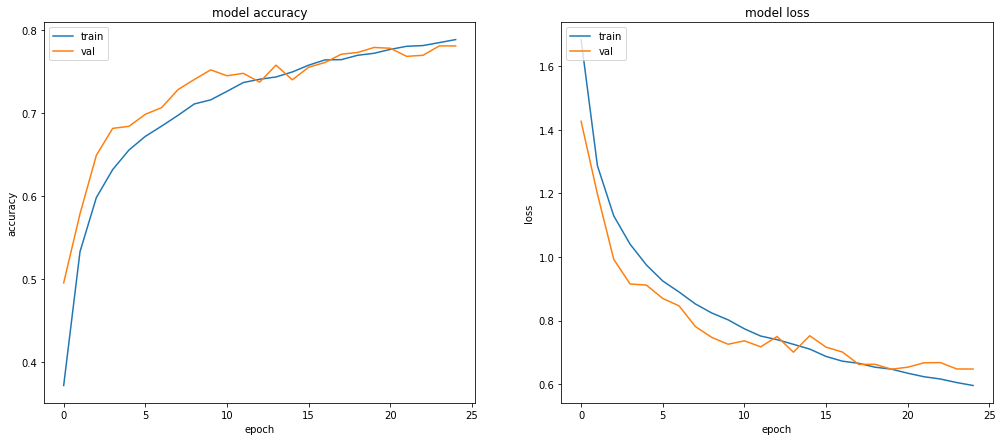

In [9]:
paramsCNN  = [64, 4, 2, 128, 4, 2, 256, 4, 2]
paramsFCNN = [256, 256]

cnn_2layer2 = cnnModels(x_train, x_test, y_train, y_test, paramsCNN, paramsFCNN, 25, 64, 'adam', True, 0.4, 3)

predicted [3 8 8 0 6 6 1 2 3 9 0 9 4 7 9 6 5 7 8 6]
y_test [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]
(2250, 32, 32, 3)
Model prediction: Bird


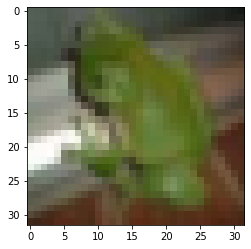

Model prediction: Truck


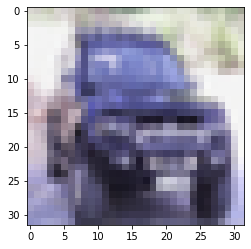

Model prediction: Deer


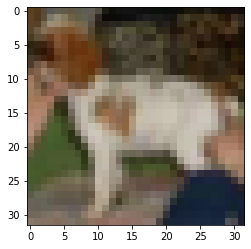

Model prediction: Frog


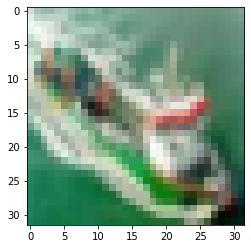

Model prediction: Deer


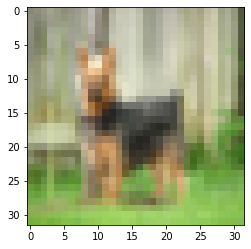

Model prediction: Deer


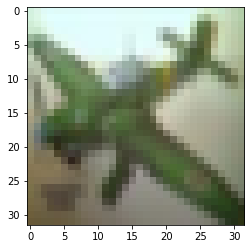

Model prediction: Cat


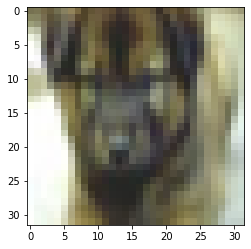

Model prediction: Cat


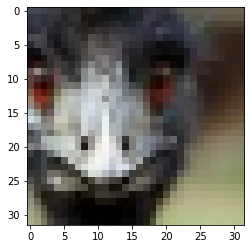

Model prediction: Airplane


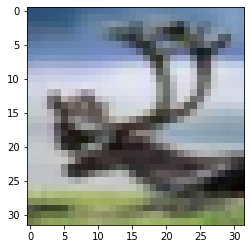

Model prediction: Frog


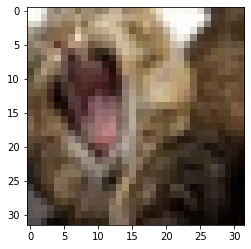

Model prediction: Cat


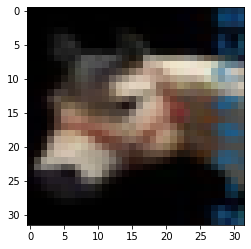

Model prediction: Cat


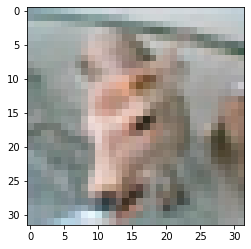

Model prediction: Cat


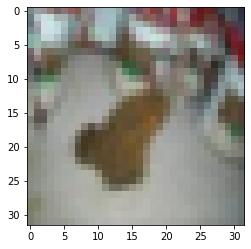

Model prediction: Dog


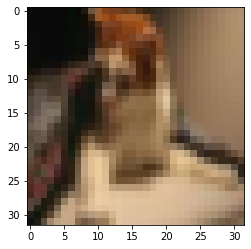

Model prediction: Truck


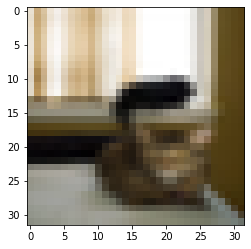

Model prediction: Frog


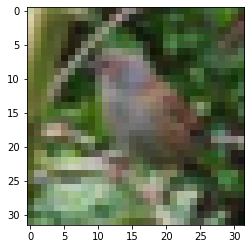

Model prediction: Dog


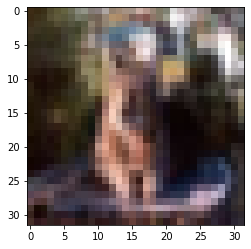

Model prediction: Truck


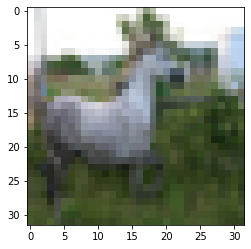

Model prediction: Airplane


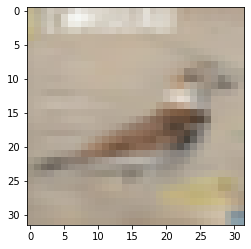

Model prediction: Truck


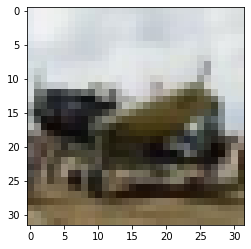

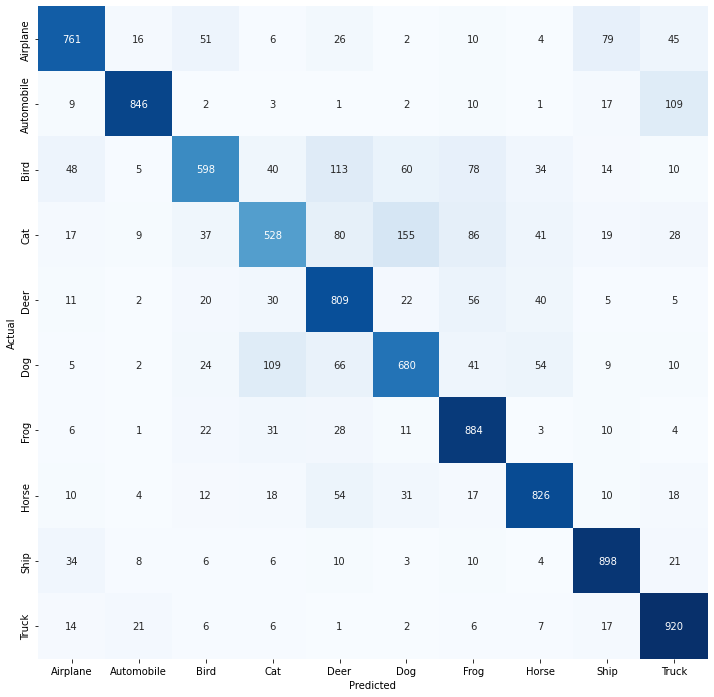

In [10]:
#show some missclassified images and the confusion matrix of the best CNN model
maskCNN_2layers = show_missclassified_img(cnn_2layer2, x_test, y_test_init, 20, labels, False, True)

Correct label: Ship


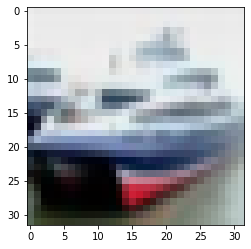

Correct label: Airplane


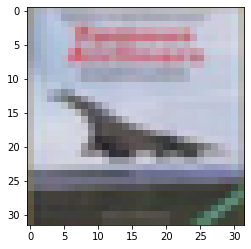

Correct label: Automobile


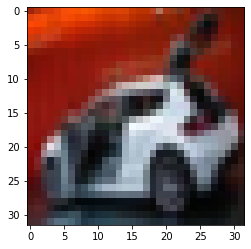

Correct label: Airplane


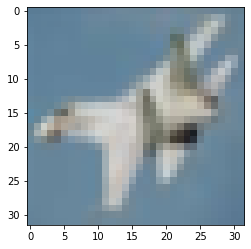

Correct label: Horse


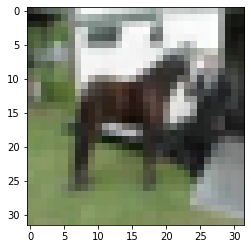

Correct label: Deer


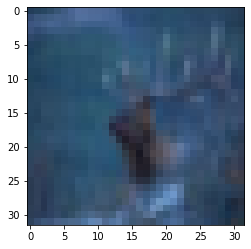

Correct label: Bird


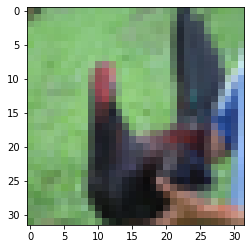

Correct label: Deer


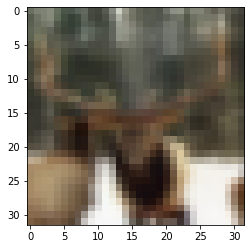

Correct label: Truck


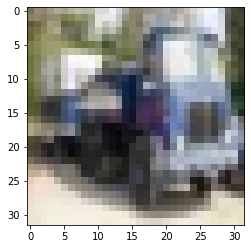

Correct label: Dog


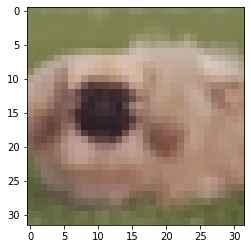

Correct label: Deer


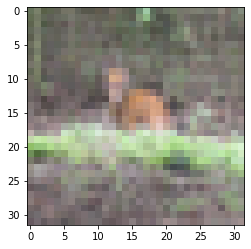

Correct label: Deer


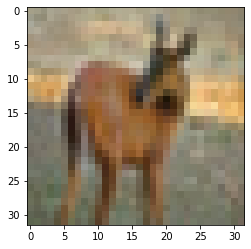

Correct label: Automobile


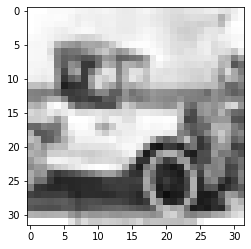

Correct label: Truck


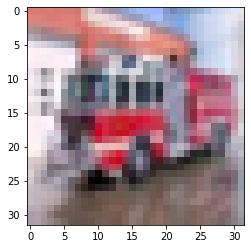

Correct label: Dog


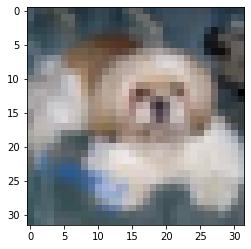

Correct label: Dog


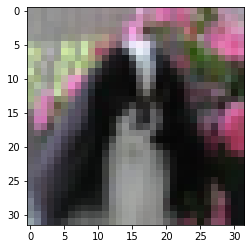

Correct label: Truck


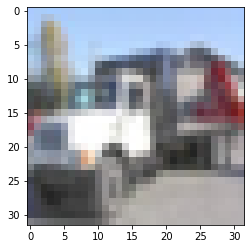

Correct label: Cat


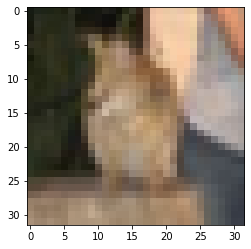

Correct label: Truck


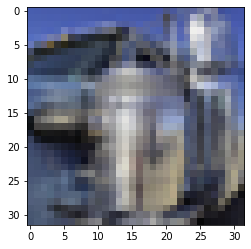

Correct label: Horse


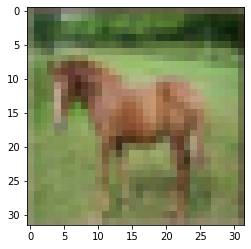

In [11]:
#Compare CNN and FCNN (show some images that were missclassified by the simple FCNN
#model, but correctely classified by the CNN)
compareResults(maskCNN_2layers, maskFCNN, y_test_init, labels, 20)

**Experiments with grayscaled images (1 channel)**

In [37]:
x_train, x_test, y_train, y_test, y_test_init = data_preprocessing(cifar10, True)

grayscaled shape x_train (50000, 32, 32, 1)
grayscaled shape x_test (10000, 32, 32, 1)


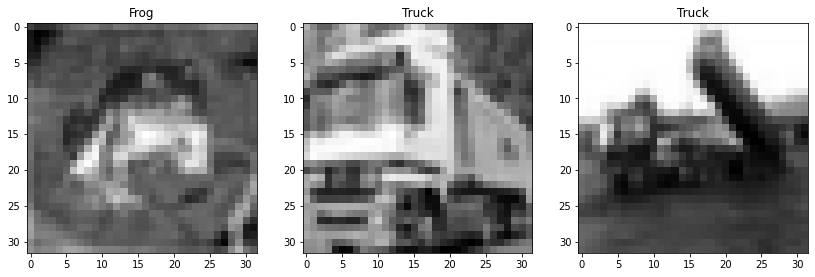

In [38]:
show_img(x_train, y_train, labels, True)

In [39]:
#Number of principal components, that remain 90% of variance information
check_var_pca(x_train, 0.9, 5, 5)

counter: 5  varinace:  0.5857361050892147
counter: 10  varinace:  0.6915544997625614
counter: 15  varinace:  0.7444003435854868
counter: 20  varinace:  0.7774253111788649
counter: 25  varinace:  0.8020109099373468
counter: 30  varinace:  0.8208241673169606
counter: 35  varinace:  0.8357838922849725
counter: 40  varinace:  0.8485469132325271
counter: 45  varinace:  0.8592670826979119
counter: 50  varinace:  0.8684692318522831
counter: 55  varinace:  0.8766480401596282
counter: 60  varinace:  0.8840271880287283
counter: 65  varinace:  0.890460836146005
counter: 70  varinace:  0.8962633791756868
counter: 75  varinace:  0.9015489671577591


80

In [40]:
#Number of principal components, that remain 95% of variance information
check_var_pca(x_train, 0.95, 10, 100)

counter: 100  varinace:  0.9223739990763691
counter: 110  varinace:  0.9284789627092246
counter: 120  varinace:  0.9340696585634245
counter: 130  varinace:  0.9390440929556526
counter: 140  varinace:  0.9434979709768294
counter: 150  varinace:  0.9474512298681309
counter: 160  varinace:  0.9510182859716279


170

In [41]:
#first 165 pc (remain 95% of initial variance information)
x_train_reduced, x_test_reduced = myPca(x_train, x_test, 165)
print(x_train_reduced.shape)
print(x_test_reduced.shape)

(50000, 165)
(10000, 165)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 300)               49800     
                                                                 
 dropout_46 (Dropout)        (None, 300)               0         
                                                                 
 dense_61 (Dense)            (None, 300)               90300     
                                                                 
 dropout_47 (Dropout)        (None, 300)               0         
                                                                 
 dense_62 (Dense)            (None, 300)               90300     
                                                                 
 dropout_48 (Dropout)        (None, 300)               0         
                                                                 
 dense_63 (Dense)            (None, 10)              

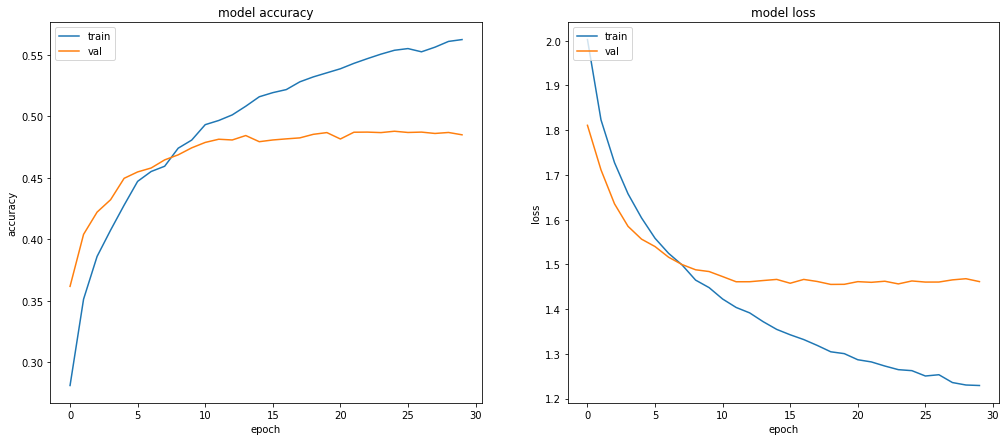

In [42]:
#All data with PCA (165 PC, 95% of init variance)
arch1 = [300, 300, 300]
simpleNN(x_train_reduced, x_test_reduced, y_train, y_test, arch1, 165, True, 0.4, False, 1)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 6, 6, 128)       

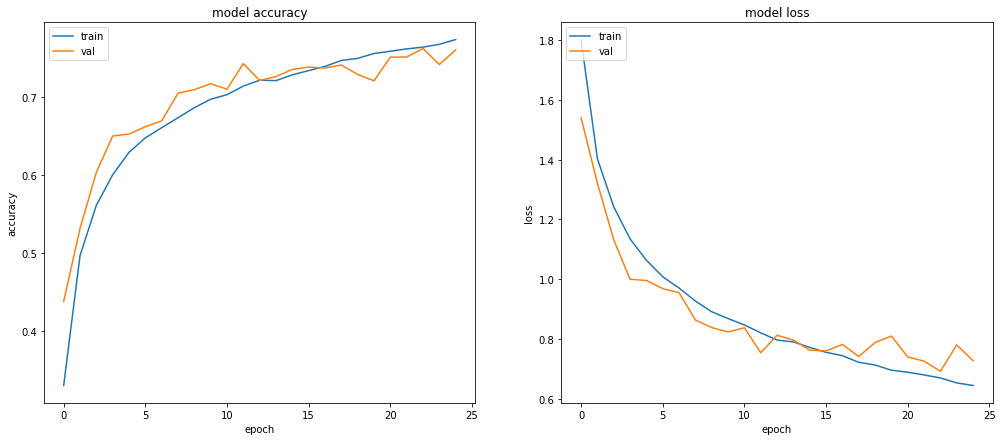

In [43]:
paramsCNN   = [64, 4, 2, 128, 4, 2, 256, 4, 2]
paramsFCNN  = [256, 256]

modelCNN_gr = cnnModels(x_train, x_test, y_train, y_test, paramsCNN, paramsFCNN, 25, 64, 'adam', True, 0.4, 1)

predicted [3 8 8 8 6 6 1 2 3 9 5 9 5 7 9 8 5 7 8 6]
y_test [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]
(2514, 32, 32, 1)
Model prediction: Ship


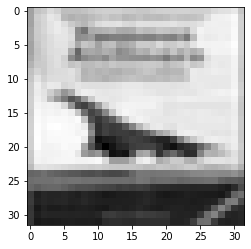

Model prediction: Bird


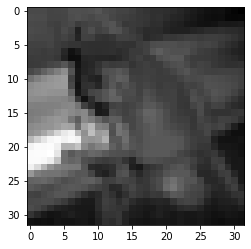

Model prediction: Truck


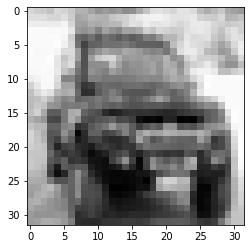

Model prediction: Dog


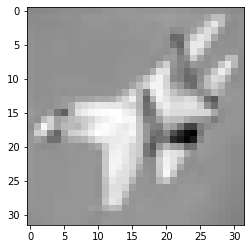

Model prediction: Deer


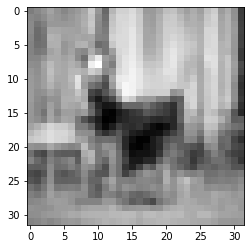

Model prediction: Cat


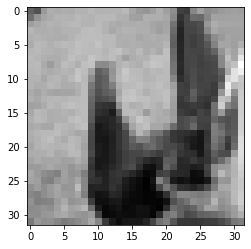

Model prediction: Cat


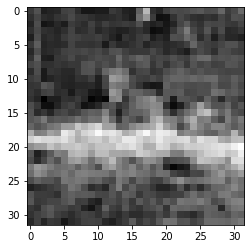

Model prediction: Ship


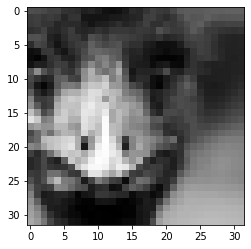

Model prediction: Frog


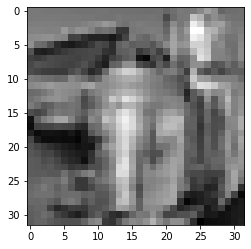

Model prediction: Dog


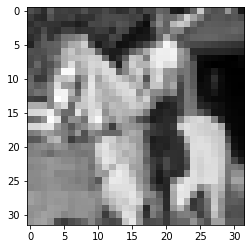

Model prediction: Dog


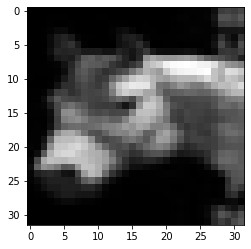

Model prediction: Dog


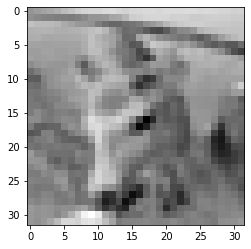

Model prediction: Deer


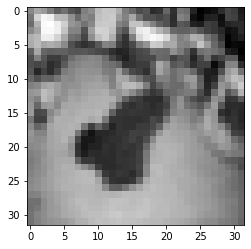

Model prediction: Dog


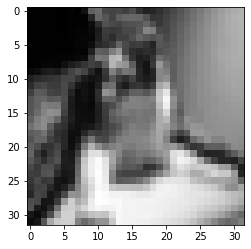

Model prediction: Airplane


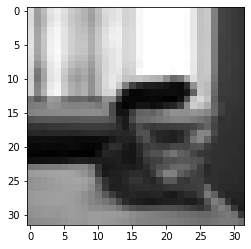

Model prediction: Frog


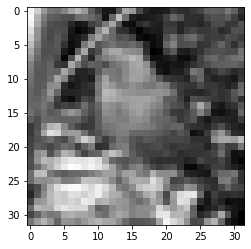

Model prediction: Truck


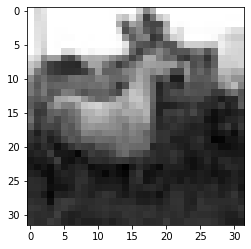

Model prediction: Airplane


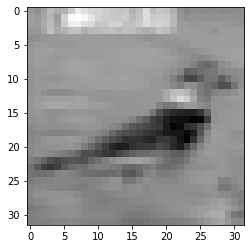

Model prediction: Cat


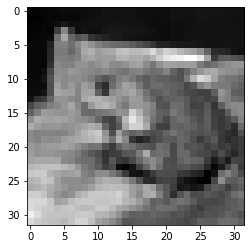

Model prediction: Ship


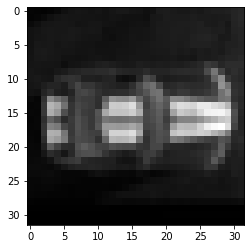

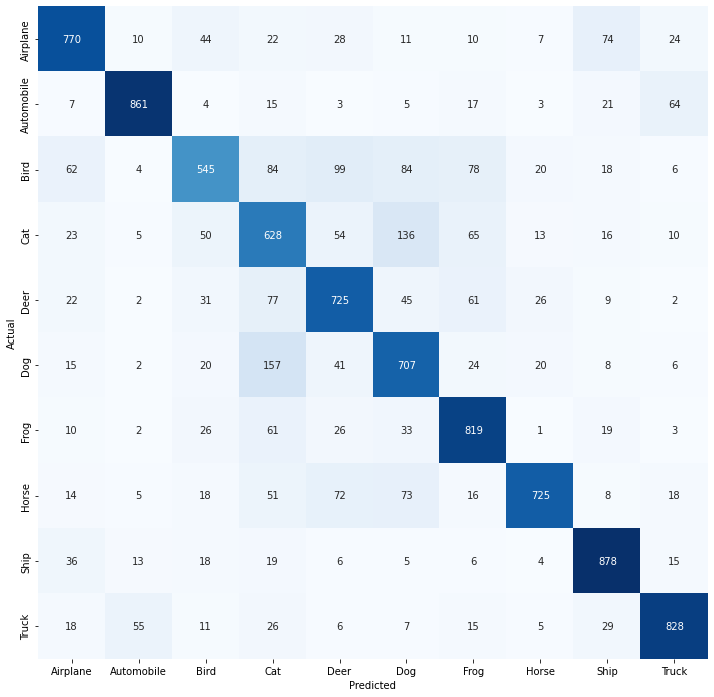

array([ True,  True,  True, ...,  True,  True,  True])

In [44]:
show_missclassified_img(modelCNN_gr, x_test, y_test_init, 20, labels, True, True)